In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import confusion_matrix, roc_curve

## Explore the data

In [2]:
esc50_csv = '../data/ESC-50-master/meta/esc50.csv'
data_path = '../data/ESC-50-master/audio/'

df = pd.read_csv(esc50_csv)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [3]:
map_class_to_id = {'car_horn':1, 'siren':1}

class_id = df['category'].apply(lambda name: map_class_to_id[name] if name in map_class_to_id.keys() else 0)
df = df.assign(target=class_id)

full_path = df['filename'].apply(lambda row: os.path.join(data_path, row))
df = df.assign(filename=full_path)

df.head(10)

,filename,fold,target,category,esc10,src_file,take
0,../data/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
1,../data/ESC-50-master/audio/1-100038-A-14.wav,1,0,chirping_birds,False,100038,A
2,../data/ESC-50-master/audio/1-100210-A-36.wav,1,0,vacuum_cleaner,False,100210,A
3,../data/ESC-50-master/audio/1-100210-B-36.wav,1,0,vacuum_cleaner,False,100210,B
4,../data/ESC-50-master/audio/1-101296-A-19.wav,1,0,thunderstorm,False,101296,A
5,../data/ESC-50-master/audio/1-101296-B-19.wav,1,0,thunderstorm,False,101296,B
6,../data/ESC-50-master/audio/1-101336-A-30.wav,1,0,door_wood_knock,False,101336,A
7,../data/ESC-50-master/audio/1-101404-A-34.wav,1,0,can_opening,False,101404,A
8,../data/ESC-50-master/audio/1-103298-A-9.wav,1,0,crow,False,103298,A
9,../data/ESC-50-master/audio/1-103995-A-30.wav,1,0,door_wood_knock,False,103995,A


In [4]:
neg, pos = np.bincount(df['target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 2000
    Positive: 80 (4.00% of total)



In [5]:
total = len(df)
positive = len(df[df['target']==1])
negative = total - positive

weight_for_0 = (1 / negative) * (total / 2.0)
weight_for_1 = (1 / positive) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 12.50


In [6]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    wav = tf.expand_dims(wav, axis=1)
#     wav = wav[:8000]
    return wav

(80000,)


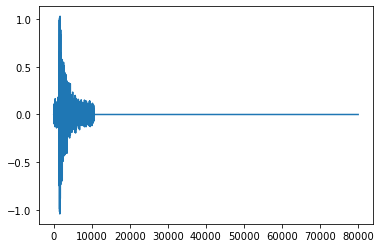

In [7]:
testing_wav_data = tf.squeeze(load_wav_16k_mono(df[df['target']==1].iloc[0,0]), axis=1)
print(testing_wav_data.shape)

_ = plt.plot(testing_wav_data)

display.Audio(testing_wav_data,rate=16000)

## Datasets

In [8]:
filenames = df['filename']
targets = df['target']
folds = df['fold']

In [9]:
def load_wav_for_map(filename, label, fold):
      return load_wav_16k_mono(filename), label, fold
    
def split_wav(filename, width, stride):
    return tf.map_fn(fn=lambda t: filename[t * stride:t * stride + width], elems=tf.range((tf.shape(filename)[0] - width) // stride), fn_output_signature=tf.float32)

def wav_not_empty(wav):
    return tf.experimental.numpy.any(wav)

def split_wav_for_flat_map(filename, label, fold):
    wavs = split_wav(filename, width=16000, stride=4000)
    labels = tf.repeat(label, tf.shape(wavs)[0])
    folds = tf.repeat(fold, tf.shape(wavs)[0])

    return tf.data.Dataset.from_tensor_slices((wavs, labels, folds))

In [10]:
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds = main_ds.map(load_wav_for_map)

split_wav_ds = main_ds.flat_map(split_wav_for_flat_map)
split_wav_ds = split_wav_ds.filter(lambda x, y, z: wav_not_empty(x))

cached_ds = split_wav_ds.cache()
train_ds = cached_ds.filter(lambda filename, target, fold: fold < 4)
val_ds = cached_ds.filter(lambda filename, target, fold: fold == 4)
test_ds = cached_ds.filter(lambda filename, target, fold: fold == 5)

remove_fold_column = lambda filenames, label, fold: (filenames, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(16).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(16).prefetch(tf.data.AUTOTUNE)

## Model

### Hyperparameters

In [11]:
LEARNING_RATE = 1e-3
EPOCHS = 50

In [12]:
input_shape = train_ds.take(1).get_single_element()[0].shape
input_shape

TensorShape([16, 16000, 1])

In [13]:
def create_model():
    model = models.Sequential([
        layers.Input(shape=(input_shape[1], 1)),
        preprocessing.Normalization(),
        layers.Conv1D(64, 8, activation='relu'),
        layers.Conv1D(64, 8, activation='relu'),
        layers.MaxPool1D(220, strides=1),
        layers.Conv1D(64, 8, activation='relu'),
        layers.Conv1D(64, 8, activation='relu'),
        layers.MaxPool1D(220, strides=1),
        layers.Conv1D(1, 8, activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=[tf.keras.metrics.TruePositives(name='True Positives'),
                       tf.keras.metrics.FalsePositives(name='False Positives'),
                       tf.keras.metrics.TrueNegatives(name='True Negatives'),
                       tf.keras.metrics.FalseNegatives(name='False Negatives'), 
                       tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
                       tf.keras.metrics.Precision(name='Precision'),
                       tf.keras.metrics.Recall(name='Recall'),
                       tf.keras.metrics.AUC(name='Precision Recall Curve', curve='PR'),
                      ])
    return model

In [14]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 16000, 1)          3         
_________________________________________________________________
conv1d (Conv1D)              (None, 15993, 64)         576       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15986, 64)         32832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15767, 64)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15760, 64)         32832     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15753, 64)         32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15534, 64)         0

## Training

In [15]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(EPOCHS/4), verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0),
               tf.keras.callbacks.ModelCheckpoint('./{epoch:02d}-{val_loss:.2f}.ckpt', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch', options=None)]
)


Epoch 1/50
1113/1113 [==============================] - 394s 348ms/step - loss: 0.6826 - True Positives: 72.0000 - False Positives: 2095.0000 - True Negatives: 15017.0000 - False Negatives: 614.0000 - Accuracy: 0.8478 - Precision: 0.0332 - Recall: 0.1050 - Precision Recall Curve: 0.0367 - val_loss: 0.6944 - val_True Positives: 247.0000 - val_False Positives: 5795.0000 - val_True Negatives: 0.0000e+00 - val_False Negatives: 0.0000e+00 - val_Accuracy: 0.0409 - val_Precision: 0.0409 - val_Recall: 1.0000 - val_Precision Recall Curve: 0.0409
Epoch 2/50
1113/1113 [==============================] - 372s 334ms/step - loss: 0.6819 - True Positives: 58.0000 - False Positives: 1974.0000 - True Negatives: 15138.0000 - False Negatives: 628.0000 - Accuracy: 0.8538 - Precision: 0.0285 - Recall: 0.0845 - Precision Recall Curve: 0.0349 - val_loss: 0.6909 - val_True Positives: 0.0000e+00 - val_False Positives: 0.0000e+00 - val_True Negatives: 5795.0000 - val_False Negatives: 247.0000 - val_Accuracy: 0.9

KeyboardInterrupt: 

In [ ]:
metrics = ['loss', 'Precision Recall Curve', 'Precision', 'Recall']
plt.figure(figsize=(18,12))
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])
    plt.legend()

## Testing

In [ ]:
model = create_model()
model.load_weights(tf.train.latest_checkpoint('./'))
results = model.evaluate(test_ds, batch_size=16, verbose=0)
predictions = model.predict(test_ds, batch_size=16)
labels = np.concatenate([out[1].numpy() for out in test_ds]).reshape(-1,1)

In [ ]:
for name, value in zip(model.metrics_names, results):
    print(f'{name}: {value:.2f}')

In [ ]:
fp, tp, _ = roc_curve(labels, predictions)
plt.figure(figsize=(12,9))
plt.plot(100*fp, 100*tp, label=name, linewidth=2)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')

In [ ]:
probability = 0.5
cm = confusion_matrix(labels, predictions > probability)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title(f'Confusion matrix @{probability:.2f}')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')